In [1]:
import requests
import random
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#Sklearn 
from matplotlib.colors import ListedColormap
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from IPython.core.display import HTML

#Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout,InputLayer
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras import regularizers 
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,LearningRateScheduler

%matplotlib inline
np.random.seed(112358)
random.seed(112358)

#### 1. Preprocess the data

In [2]:
df_flights = pd.read_csv('flights.csv')
df_flights.info()
df_flights.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ARRIVAL_DELAY        10000 non-null  float64
 1   DISTANCE             10000 non-null  int64  
 2   SCHEDULED_TIME       10000 non-null  float64
 3   MONTH                10000 non-null  int64  
 4   SCHED_DEP_HOUR       10000 non-null  int64  
 5   SCHED_ARR_HOUR       10000 non-null  int64  
 6   FLIGHT_COUNT         10000 non-null  int64  
 7   DAY_OF_WEEK          10000 non-null  int64  
 8   ORIGIN_AIRPORT       10000 non-null  object 
 9   DESTINATION_AIRPORT  10000 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 781.4+ KB


,ARRIVAL_DELAY,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK,ORIGIN_AIRPORT,DESTINATION_AIRPORT
0,23.0,2586,342.0,9,7,15,240,3,SFO,JFK
1,10.0,1235,185.0,5,6,11,366,4,LAX,DFW
2,-7.0,184,76.0,4,17,18,172,7,BOS,LGA
3,68.0,862,148.0,7,19,21,260,7,IAH,DEN
4,24.0,236,71.0,3,20,21,266,2,LAS,LAX


In [3]:
#New feature
df_flights['DELAY_OR_NOT'] = (df_flights['ARRIVAL_DELAY'] >= 15).astype(int)

delay_counts = df_flights['DELAY_OR_NOT'].value_counts().sort_index()

print("The resulting counts for our \"DELAY_OR_NOT\" response variable,\n"
"where class 1 are flights with actual arrivals 15 minutes late or later than \n"
"scheduled are: \n\n\tclass\tobservation")

for resp, value in zip(delay_counts.index, delay_counts.values):
    print(f"\t{resp} \t{value:.0f}")

The resulting counts for our "DELAY_OR_NOT" response variable,
where class 1 are flights with actual arrivals 15 minutes late or later than 
scheduled are: 

	class	observation
	0 	5069
	1 	4931


In [4]:
print('ALL MISSING VALUE ROWS')
print(df_flights[df_flights.isnull().any(axis=1)])
print('\nThere appear to be no null values')
df_flights.info()

ALL MISSING VALUE ROWS
Empty DataFrame
Columns: [ARRIVAL_DELAY, DISTANCE, SCHEDULED_TIME, MONTH, SCHED_DEP_HOUR, SCHED_ARR_HOUR, FLIGHT_COUNT, DAY_OF_WEEK, ORIGIN_AIRPORT, DESTINATION_AIRPORT, DELAY_OR_NOT]
Index: []

There appear to be no null values
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ARRIVAL_DELAY        10000 non-null  float64
 1   DISTANCE             10000 non-null  int64  
 2   SCHEDULED_TIME       10000 non-null  float64
 3   MONTH                10000 non-null  int64  
 4   SCHED_DEP_HOUR       10000 non-null  int64  
 5   SCHED_ARR_HOUR       10000 non-null  int64  
 6   FLIGHT_COUNT         10000 non-null  int64  
 7   DAY_OF_WEEK          10000 non-null  int64  
 8   ORIGIN_AIRPORT       10000 non-null  object 
 9   DESTINATION_AIRPORT  10000 non-null  object 
 10  DELAY_OR_NOT         10000 non-null

In [5]:
#Define the variables
response = 'DELAY_OR_NOT'

#Categorical Predictors
cat_pred = list(df_flights.columns[df_flights.dtypes=='object'])

#Columns to be dropped after encoding
drop_cols = ['ARRIVAL_DELAY', response]

#Encode
df_flights = pd.get_dummies(df_flights,columns = cat_pred, drop_first=True)

#Remove columns related to response
X_flights = df_flights.drop(columns=drop_cols)

y_flights = df_flights[response]

#Train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_flights, y_flights, test_size=0.2, random_state=0)
print(f'The size of the datasets are:\n\n  \tTrain \t\tTest \nX: {Xtrain.shape}\t{Xtest.shape} \nY: {ytrain.shape} \t{ytest.shape}')

#Standardize the values
Xtrain_std = Xtrain.copy()
Xtest_std = Xtest.copy()

scaler = StandardScaler()
Xtrain_std[Xtrain.columns] = scaler.fit_transform(Xtrain)
Xtest_std[Xtrain.columns] = scaler.fit_transform(Xtest)

The size of the datasets are:

  	Train 		Test 
X: (8000, 808)	(2000, 808) 
Y: (8000,) 	(2000,)


#### 2. Model

In [6]:
nodes = 15

NN_model = Sequential()
NN_model.add(InputLayer(input_shape=(Xtrain.shape[1])))
NN_model.add(Dense(nodes, activation='relu'))
NN_model.add(Dense(nodes,activation='relu'))
NN_model.add(Dense(1,activation='sigmoid'))

NN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                12135     
_________________________________________________________________
dense_1 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 16        
Total params: 12,391
Trainable params: 12,391
Non-trainable params: 0
_________________________________________________________________


In [7]:
NN_model.compile(loss='binary_crossentropy',optimizer=Adam(), metrics=['accuracy'])
history_NN = NN_model.fit(Xtrain_std, 
                          ytrain, 
                          batch_size=128, 
                          validation_split=0.2, 
                          epochs = 15, 
                          verbose=2)

Train on 6400 samples, validate on 1600 samples
Epoch 1/15
6400/6400 - 1s - loss: 0.7398 - accuracy: 0.5203 - val_loss: 0.6998 - val_accuracy: 0.5675
Epoch 2/15
6400/6400 - 0s - loss: 0.6514 - accuracy: 0.6358 - val_loss: 0.6728 - val_accuracy: 0.6369
Epoch 3/15
6400/6400 - 0s - loss: 0.5965 - accuracy: 0.7033 - val_loss: 0.6503 - val_accuracy: 0.6575
Epoch 4/15
6400/6400 - 0s - loss: 0.5482 - accuracy: 0.7289 - val_loss: 0.6459 - val_accuracy: 0.6687
Epoch 5/15
6400/6400 - 0s - loss: 0.5164 - accuracy: 0.7494 - val_loss: 0.6504 - val_accuracy: 0.6794
Epoch 6/15
6400/6400 - 0s - loss: 0.4970 - accuracy: 0.7581 - val_loss: 0.6616 - val_accuracy: 0.6775
Epoch 7/15
6400/6400 - 0s - loss: 0.4823 - accuracy: 0.7667 - val_loss: 0.6698 - val_accuracy: 0.6756
Epoch 8/15
6400/6400 - 0s - loss: 0.4720 - accuracy: 0.7734 - val_loss: 0.6812 - val_accuracy: 0.6781
Epoch 9/15
6400/6400 - 0s - loss: 0.4626 - accuracy: 0.7769 - val_loss: 0.6943 - val_accuracy: 0.6831
Epoch 10/15
6400/6400 - 0s - loss:

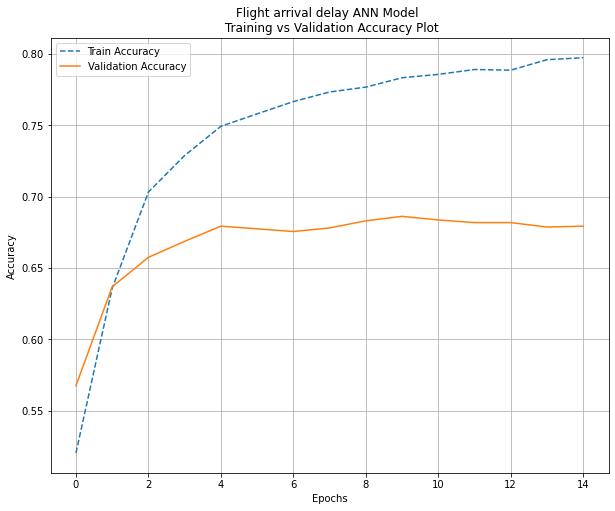

In [8]:
#plotting the MSE loss of the model
plt.rcParams["figure.figsize"] = (10,8)
plt.title("Flight arrival delay ANN Model \n Training vs Validation Accuracy Plot")
plt.plot(history_NN.history['accuracy'],'--',label='Train Accuracy')
plt.plot(history_NN.history['val_accuracy'],label='Validation Accuracy')
plt.legend()

# Setting the axis labels
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

In [9]:
#Model evaluation
acc = NN_model.evaluate(Xtrain_std,ytrain)
acc2 = NN_model.evaluate(Xtest_std,ytest)

print(f'Results for Training: Accuracy: {acc[1]:.5f}, Loss: {acc[0]:.5f}')
print(f'            Testing: Accuracy: {acc2[1]:.5f}, Loss: {acc2[0]:.5f}')

2000/2000 [==============================] - 0s 54us/sample - loss: 0.6287 - accuracy: 0.7055
Results for Training: Accuracy: 0.78562, Loss: 0.47611
            Testing: Accuracy: 0.70550, Loss: 0.62867


#### 3. Fit and Examine a 'proxy' model

In [10]:
#Generate new ytrain from NN_model's class predictions
ytrain_nn = (NN_model.predict(Xtrain_std) > 0.5).astype(int).ravel()

In [11]:
#Define a logistic regression model
logreg = LogisticRegression(C=0.01,max_iter=10000).fit(Xtrain_std,ytrain_nn)

print("Fitting a Logistic Regression model to our NN Model's predictions")
print('These are the scores obtained by the logreg model \n\nModified Train: {:.4f}\nTest: {:.4f}'.format(
    logreg.score(Xtrain_std,ytrain_nn),
    logreg.score(Xtest_std,ytest)))
print(f'\nNN_model Test score was; {acc2[1]:.4f}')
print('\nNote: The accuracy of the logreg is very close to that of the NN_model')

Fitting a Logistic Regression model to our NN Model's predictions
These are the scores obtained by the logreg model 

Modified Train: 0.9399
Test: 0.7140

NN_model Test score was; 0.7055

Note: The accuracy of the logreg is very close to that of the NN_model


In [12]:
#Perform Permuation importance on the logreg model

#Run permutaion importance
perm_results =  permutation_importance(logreg, Xtrain_std,ytrain_nn, n_jobs=-1)

# Calculate relative importance of top 10 perdictors
relimp10 = np.flip(np.sort(perm_results.importances_mean)[-10:])/perm_results.importances_mean.max()
#Find the index of those important features
relimp10_idx = np.flip(np.argsort(perm_results.importances_mean)[-10:])
#get the columns names from the indexes
relimp10_preds = [Xtrain.columns[i] for i in relimp10_idx]


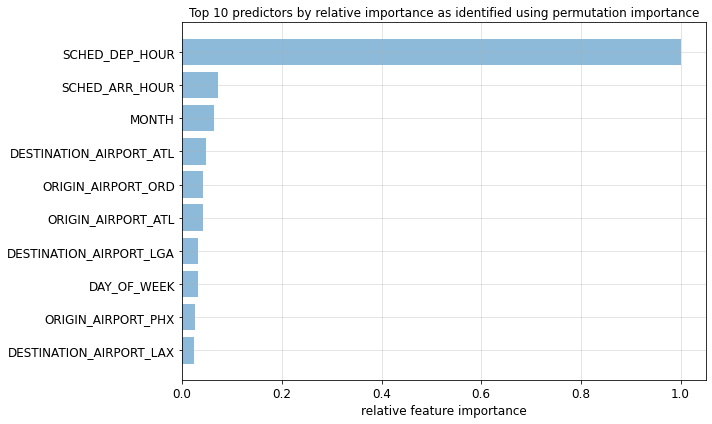

In [13]:
#plot the results from permutation importance
fig, ax = plt.subplots(figsize=(10,6))
plt.title('Top 10 predictors by relative importance as identified using permutation importance')
ax.barh(relimp10_preds[::-1],relimp10[::-1],alpha=0.5)
ax.tick_params(labelsize=12)
ax.set_xlabel("relative feature importance", fontsize = 12)
ax.grid(':', alpha=0.4)
plt.tight_layout()
plt.show()

#### 4. Visualize important features

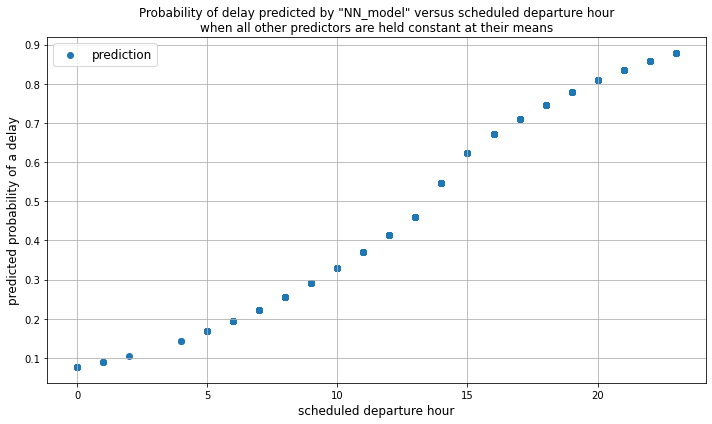

In [14]:
# your code here

# create copy of x_train dataframe with all predictor mean values
# except for SCHED_DEP_HOUR
Xtrain_mean = Xtrain_std.copy()

for col in Xtrain_mean.columns:
    if col == "SCHED_DEP_HOUR":
        pass
    else:
        Xtrain_mean[col] = Xtrain_mean[col].mean()

# predict probabilities using mean values dataframe
NN_model_proba_train_means = NN_model.predict(Xtrain_mean.values)

# plot predictors as directed
plt.figure(figsize=(10,6))
plt.title("Probability of delay predicted by \"NN_model\" versus scheduled departure hour\nwhen all other predictors are held constant at their means",)
plt.scatter(Xtrain["SCHED_DEP_HOUR"],
            NN_model_proba_train_means,
            label="prediction")


plt.xlabel("scheduled departure hour", fontsize=12)
plt.ylabel("predicted probability of a delay", fontsize=12)
plt.grid()
plt.legend(fontsize=12, loc=2)
        
plt.tight_layout()
plt.show()

In [15]:
def plot_2d(tfmodel,Xscaled,Xoriginal, pred1,pred2):
    
    """
    tfmodel: trained tensorflow model
    Xscaled: dataframe of the scaled data used to fit tf_model
    Xoriginal: dataframe of the original unscaled X data
    pred1: string name of x-axis predictor column 
    pred2: string name of y-axis predictor column    
    """
    classes = ['0', '1']
    color = ['#25c5da','#2937d6']
    Xtrain_mean = Xscaled.copy()
    
    for col in Xtrain_mean.columns:
        if col in [pred1,pred2]:
            pass
        else:
            Xtrain_mean[col] = Xtrain_mean[col].mean()
            
    tfmodel_proba = tfmodel.predict(Xtrain_mean.values)
    
    # plot predictors as directed
    plt.figure(figsize=(10,6))
    plt.title(f"\"NN_model\" training predictions\nby {pred1} and {pred2}\n with all other predictors are held constant at their means")
    plt.scatter(Xoriginal[pred1],
                Xoriginal[pred2],
                c=tfmodel_proba.ravel(),
                cmap=ListedColormap(color),
                label="Training\nObservation")
    cbar = plt.colorbar()
    plt.xlabel(pred1, fontsize=12)
    plt.ylabel(pred2, fontsize=12)
    plt.grid()
    plt.legend(fontsize=12, loc=2)

    plt.tight_layout()
    plt.show()

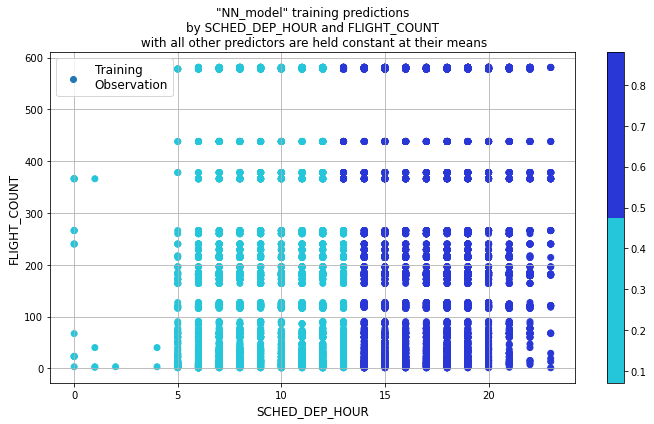

In [16]:
plot_2d(NN_model,Xtrain_std,Xtrain,'SCHED_DEP_HOUR','FLIGHT_COUNT')

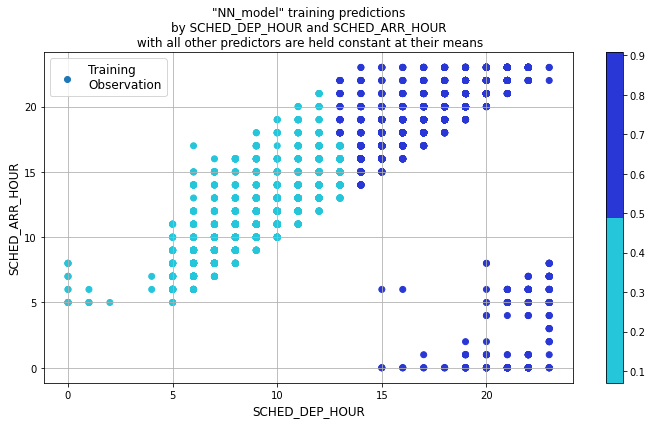

In [17]:
plot_2d(NN_model,Xtrain_std,Xtrain,pred1='SCHED_DEP_HOUR',pred2='SCHED_ARR_HOUR')

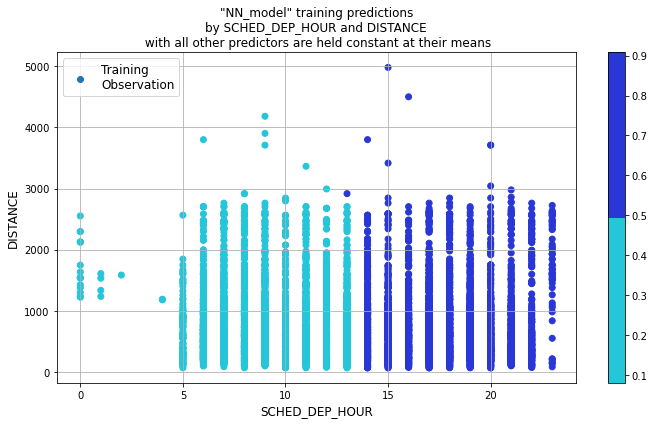

In [18]:
plot_2d(NN_model,Xtrain_std,Xtrain,'SCHED_DEP_HOUR','DISTANCE')

#### 5. Bootstrapping prediction intervals

In [19]:
def progressbar(n_steps, n_total):
    """The following function will print a autoupdating progress bar based on the current iteration of steps"""
    n_steps +=1
    barlen=50
    progress = n_steps/n_total
    block = int(round(barlen*progress))
    status = ""
    if n_steps==n_total:
        status = "Done...\r\n\n"
    text = "\r [{0}] {1}/{2} {3}".format("="*block+"-"*(barlen-block),n_steps,n_total,status)
    sys.stdout.write(text)
    sys.stdout.flush()

In [40]:
%%time
#Performe the bootsrapping
n_bootstraps = 50
predictions_array = np.zeros((len(ytest),n_bootstraps))
len_train = len(Xtrain_std)

#set nn model related parameters
nodes = 15
batch_size = 128
epochs = 15
validation_split = 0.2
verbose = 0 

for i in range(n_bootstraps):
    progressbar(i,n_bootstraps)
    
    NN_model_boot = Sequential()
    
    NN_model_boot.add(InputLayer(input_shape=(Xtrain_std.shape)[1],))
    NN_model_boot.add(Dense(nodes, activation='relu'))
    NN_model_boot.add(Dense(nodes, activation='relu'))
    NN_model_boot.add(Dense(1, activation='sigmoid'))
    
    NN_model_boot.compile(loss = 'binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    idx_array = np.random.choice(np.array(range(len_train)), size = len_train, replace=True)
    
    NN_model_boot.fit(Xtrain_std.values[idx_array], ytrain.values[idx_array], 
                      batch_size=batch_size,
                      validation_split = validation_split,
                      epochs = epochs,
                      verbose = verbose)
    
    predictions_array[:,i] = NN_model_boot.predict(Xtest_std.values).ravel()
print()

 [==================================================] 50/50 Done...


Wall time: 2min 13s


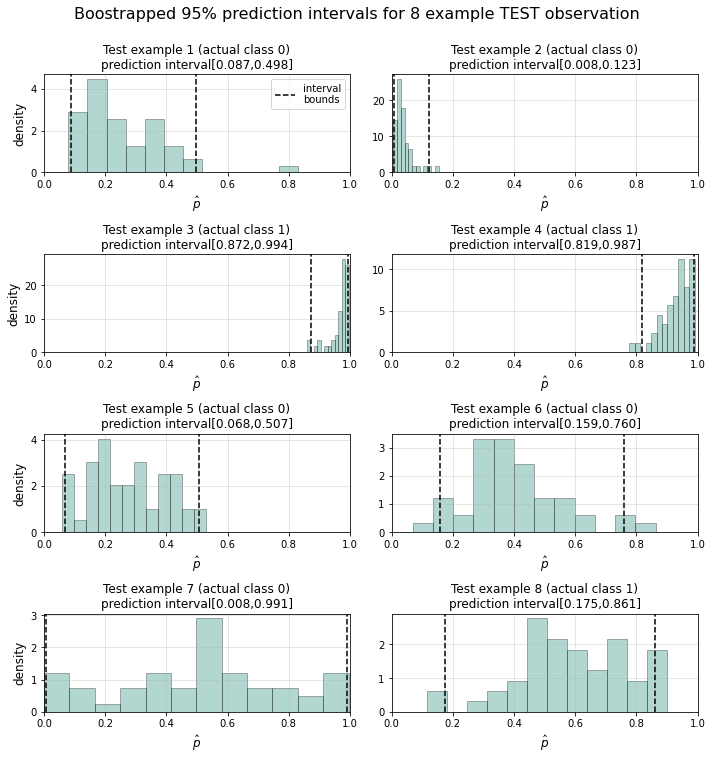

In [41]:
## Plotting distributions
len_test = len(ytest)
test_obs_idx = np.random.choice(np.array(range(len_test)),size=8, replace=False)

fig, ax = plt.subplots(4,2, sharey=False, figsize=(10,10.5))

plt.suptitle('Boostrapped 95% prediction intervals for 8 example TEST observation', 
             y=1, 
             fontsize=16)

for i, (obs,ax) in enumerate(zip(test_obs_idx, ax.flat)):
    upperbound = np.percentile(predictions_array[obs], 97.5)
    lowerbound = np.percentile(predictions_array[obs], 2.5)
    ax.hist(predictions_array[obs], bins=12, density=True, alpha=0.3, edgecolor='k', color='#007D66')
    ax.axvline(lowerbound, color='k', linestyle='--', label='interval\nbounds')
    ax.axvline(upperbound, color='k', linestyle='--')
    ax.set_title(f'Test example {i+1} (actual class {ytest.values[obs]})\nprediction interval[{lowerbound:.3f},{upperbound:.3f}]')
    ax.set_xlim(0,1)
    ax.set_xlabel('$\hat{p}$', fontsize=12)
    ax.grid(':',alpha=0.4)
    
    if i%2 ==0:
        ax.set_ylabel('density', fontsize=12)
    if i==0:
        ax.legend()
        
plt.tight_layout()
plt.show()    

Now what we are looking at are 8 probability distribution spread across 50 runs(bootstraps) showing where 95% of the prediction probabilities end up when predicting thorugh the model.

Each of the 8 graphs represents 1 Test sample case of predictors and shows the models response over 50 cycles of training and prediction.
From this random sampling of observations we can gleam, that in some cases diplayed above the model's performance is excellent with 95% of the responses being closely grouped. Showing us that the model can predict the right class with a high degree of certainty.
This means most probability predictions fall on the appropriate side of $\hat{p}=0.5$ therefore predicting correctly.

On the other hand we have some sample with much less certainty where the distribution is spread out or the span of the distribution covers the majority of the probability range.
Even less frequently we are seeing the model predict the wrong class with a high degree of confidence. These distributions tend to mirror the ones we would see for "High certainty" correct predictions, just on the wrong side of the $\hat{p}=0.5$ threshold

The take away is that the model works well and is certain of its deceisions in "Most Cases".

#### 6. Abstain bagging model

In [43]:
#convert bootstrapped probabilities to class prediction
pred_class = np.round(predictions_array).astype(int)

#Generate bagged class predictions and accuracy for all obs
#decide the final class preiction for each of the 2000 predictor samples
y_bagged_pred = np.round(pred_class.mean(axis=1)).astype(int)
#Calculate accuracy score using the above
y_bagged_accuracy = accuracy_score(y_bagged_pred, ytest)

#Calculate the amount of class allocations(0 or 1) for each predictor sample in ratios
prop_1 = (pred_class==1).sum(axis=1)/n_bootstraps
prop_0 = (pred_class==0).sum(axis=1)/n_bootstraps

#Calculate PPR
#PPR: For class 1 PPR = ratio of 0s, For class 0 PPR = ratios of 1s for each predictor sample
PPR = np.zeros(len(ytest))
PPR[y_bagged_pred == 1] = 1 - prop_1[y_bagged_pred == 1]
PPR[y_bagged_pred == 0] = 1 - prop_0[y_bagged_pred == 0]

In [44]:
min_ppr = PPR.min()
step = 0.001
max_ppr = PPR.max()
ppr_threshold_list = np.arange(min_ppr, max_ppr, step)
score_dict = {}
prop_signif_dict = {}

for ppr_thresh in ppr_threshold_list:
    bool_array = PPR <= ppr_thresh
    score_dict[ppr_thresh] = accuracy_score(y_bagged_pred[bool_array], ytest[bool_array])
    prop_signif_dict[ppr_thresh] = sum(bool_array)/len(ytest)
    

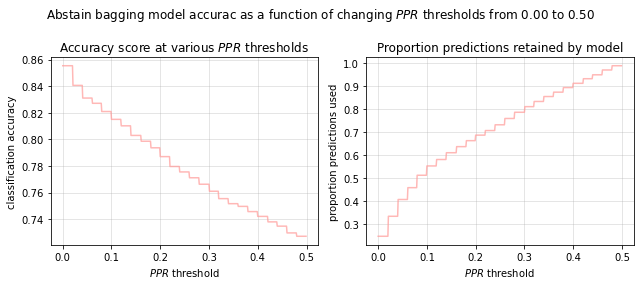

The accuracy of our bagged model using all TEST predictions
 and n=50 bootstraps is: 0.7260


In [45]:
fig, ax = plt.subplots(1,2, sharex=True, figsize=(9,4))

plt.suptitle(f'Abstain bagging model accurac as a function of changing $PPR$ thresholds from {min_ppr:.2f} to {max_ppr:.2f}')

y_labels = ['classification accuracy','proportion predictions used']
ax_titles = ['Accuracy score at various $PPR$ thresholds', 'Proportion predictions retained by model']

for t_dict, ax, title, y_label in zip([score_dict, prop_signif_dict], ax.flat, ax_titles, y_labels):
    ax.plot(list(t_dict.keys()), list(t_dict.values()), alpha=0.7, color='#FF9A98')
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.set_xlabel('$PPR$ threshold')
    ax.grid(':', alpha=0.4)

fig.subplots_adjust(top=0.22)
plt.tight_layout()
plt.show()

print(f'The accuracy of our bagged model using all TEST predictions\n and n={n_bootstraps} bootstraps is: {y_bagged_accuracy:.4f}')

As PPR decreases we compromise on the number of data points that the abstain bagging mode finds "Signigicant" and we can see that in the right plot with about 30% of the data used for PPR thresh of 0.0. We can also see at lower PPR thresholds we have higher accuracy as the model is more certain about its decision for these data points, thus making more accuracte predictions(kinda like cherry picking results for high accuracy score).

So by sacrifising about 80% of the data set we have gained additional 15 points in terms of accuracy.